# Imports and Data Munging

In [1]:
from __future__ import print_function

import sys
import pyodbc
import datetime as dt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import math

#make the layout full width
from IPython.display import clear_output
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

pd.options.display.max_columns = None

#prefer locally cached copy of SQL Server data
runSql = False

# Load Data

This is a utility function to map track names to the track name is use by TAB.  All 'RANDWICK Kensington' meetings have been changes in the database to Randwick

In [2]:
def ChangetoTabTrackName(df):
                    
    df = df.replace('MORPHETTVILLE PARKS', 'MORPHETTVILLE')
    df = df.replace('ROYAL RANDWICK', 'RANDWICK')
    df = df.replace('RANDWICK KENSINGTON', 'RANDWICK')
    df = df.replace('DEVONPORT SYNTHETIC', 'DEVONPORT')
    df = df.replace('DEVONPORT TAPETA SYNTHETIC', 'DEVONPORT')
    df = df.replace('KENSINGTON', 'RANDWICK')
    df = df.replace('GEELONG SYNTHETIC', 'GEELONG')
    df = df.replace('ROSEHILL GARDENS', 'ROSEHILL')
    df = df.replace('CANTERBURY PARK', 'CANTERBURY')
    df = df.replace('PAKENHAM SYNTHETIC', 'PAKENHAM')
    df = df.replace('ESPERANCE BAY', 'ESPERANCE')
    df = df.replace('SANDOWN HILLSIDE', 'SANDOWN')
    df = df.replace('SANDOWN-HILLSIDE', 'SANDOWN')
    df = df.replace('SANDOWN LAKESIDE', 'SANDOWN') 
    df = df.replace('SANDOWN-LAKESIDE', 'SANDOWN')
    df = df.replace('LADBROKES PARK HILLSIDE', 'SANDOWN')
    df = df.replace('LADBROKES PARK LAKESIDE', 'SANDOWN')
    df = df.replace('PINJARRA PARK', 'PINJARRA')
    df = df.replace('BALLARAT SYNTHETIC', 'BALLARAT') 
    df = df.replace('RACING.COM PARK SYN', 'PAKENHAM') 
    df = df.replace('RACING.COM PARK', 'PAKENHAM') 
    df = df.replace('PIONEER PARK', 'ALICE SPRINGS') 
    df = df.replace('KINGSCOTE', 'KANGAROO ISL')  
    df = df.replace('GEELONG SYNTHETIC', 'GEELONG') 
    df = df.replace('WAGGA RIVERSIDE', 'WAGGA') 
    df = df.replace('ASCOT PARK', 'ASCOT')
    df = df.replace('CANBERRA ACTON', 'CANBERRA')
    df = df.replace('RANDWICK INS', 'RANDWICK')
    df = df.replace('BELMONT PARK', 'BELMONT')
    df = df.replace('BALLARAT SYN', 'BALLARAT')
    df = df.replace('MT GAMBIER', 'MOUNT GAMBIER')
    df = df.replace('SPENDTHRIFT AUSTRALIA PARK', 'WERRIBEE')
    df = df.replace('BET365 PARK KILMORE', 'KILMORE')
    df = df.replace('BET365 ', '')  
    df = df.replace('SPORTSBET-BALLARAT', 'BALLARAT')
    df = df.replace('MURRAY BRIDGE (NOT USED)', 'MURRAY BRIDGE')
    df = df.replace(' SYN', '')
    df = df.replace('AQUIS PARK GOLD COAST', 'GOLD COAST')
    df = df.replace('CRANBOURNE-TRN', 'CRANBOURNE')
    
    return df

connString = ''

## Every Race Data

The data has been downloaded from historical CSV files (http://everyrace.com/WizArchive.asp) and imported into SQL Server with no pre-procssessing.

Field definitions are available at http://everyrace.com/HowtoreadwizardA4.pdf and http://www.everyrace.com/WizardCSV.PDF

In [3]:
rawSql = \
'''
select [meeting], [race_number], [distance], [prize_money], convert(date, [date], 103) as [date], [tab_number], 
[horse], Sex
from [dbo].[EveryRace]
order by convert(date, [date], 103), meeting, race_number
'''
if runSql:
    cnxn = pyodbc.connect(connString)
    raw = pd.read_sql(rawSql,cnxn)
    raw.to_csv('raw.csv', index=False, date_format='%Y-%m-%d')

raw= pd.read_csv('raw.csv')
raw = ChangetoTabTrackName(raw)
raw['date'] = pd.to_datetime(raw['date'], format="%Y-%m-%d")

raw.head()

,meeting,race_number,distance,prize_money,date,tab_number,horse,Sex
0,BUNBURY,1,1008,"12,500",2016-01-01,1,PRINCE MOURITZ,G
1,BUNBURY,1,1008,"12,500",2016-01-01,2,C'EST PARTI,G
2,BUNBURY,1,1008,"12,500",2016-01-01,3,GUEST EXPRESS,G
3,BUNBURY,1,1008,"12,500",2016-01-01,4,KRYSTAL SHOT,G
4,BUNBURY,1,1008,"12,500",2016-01-01,5,PLATELAYER,C


## Add TAB data

In [4]:
runnerSql = '''
SELECT rnr.RunnerName, rnr.RunnerNumber, rnr.FixedWinOpen, rnr.FixedWin, rnr.FixedPlace,
m.MeetingDate, m.MeetingName, r.RaceNumber, r.RaceClassConditions,
JSON_VALUE(m.[RawData], '$.location') as State
from TabRace r 
inner join TabMeeting m on m.TabMeetingId = r.TabMeetingId 
inner join TabRunner rnr on rnr.[TabRaceId] = r.TabRaceId
where m.MeetingDate >= '1 Jan 2016' and m.RaceType = 'R'
and JSON_VALUE(m.[RawData], '$.location') in ('NSW', 'QLD', 'VIC', 'ACT', 'TAS', 'SA', 'NT', 'WA') 
and (RaceClassConditions like '%MDN%' or RaceClassConditions like '%MSW%' or RaceClassConditions like' %MW%'  or RaceClassConditions like '%MLY%')
'''
if runSql:
    cnxn = pyodbc.connect(connString)
    runners = pd.read_sql(runnerSql,cnxn)
    runners.to_csv('runners.csv', index=False, date_format='%Y-%m-%d')

runners = pd.read_csv('runners.csv')
runners['MeetingDate'] = pd.to_datetime(runners['MeetingDate'], format="%Y-%m-%d")

merged1 = pd.merge(raw, runners, how='left', left_on=['date','meeting', 'race_number', 'tab_number'], right_on = ['MeetingDate', 'MeetingName', 'RaceNumber', 'RunnerNumber'])

In [5]:
#debug code for looking at failed merges

#merged1[merged1.MeetingName.isnull()].meeting.unique()
#merged1[(merged1.meeting == "ASCOT") & merged1.MeetingName.isnull()]
#runners[(runners.MeetingName == "ASCOT")&(runners.MeetingDate == "2016-12-10") &(runners.RaceNumber == 3)]

In [6]:
def StateCat(state):
    if state == "ACT": return 0.0;
    if state ==  "NSW": return 1.0;
    if state ==  "NT": return 2.0;
    if state ==  "QLD": return 3.0;
    if state ==  "SA": return 4.0;
    if state ==  "TAS": return 5.0;
    if state ==  "VIC": return 6.0;
    if state ==  "WA": return 7.0;

merged1['STATE_CAT'] = merged1['State'].apply(lambda x: StateCat(x))
merged1.head()

,meeting,race_number,distance,prize_money,date,tab_number,horse,Sex,RunnerName,RunnerNumber,FixedWinOpen,FixedWin,FixedPlace,MeetingDate,MeetingName,RaceNumber,RaceClassConditions,State,STATE_CAT
0,BUNBURY,1,1008,"12,500",2016-01-01,1,PRINCE MOURITZ,G,PRINCE MOURITZ,1.0,2.8,5.0,1.80,2016-01-01,BUNBURY,1.0,2Y-MDN,WA,7.0
1,BUNBURY,1,1008,"12,500",2016-01-01,2,C'EST PARTI,G,C'EST PARTI,2.0,21.0,26.0,6.00,2016-01-01,BUNBURY,1.0,2Y-MDN,WA,7.0
2,BUNBURY,1,1008,"12,500",2016-01-01,3,GUEST EXPRESS,G,GUEST EXPRESS,3.0,8.5,3.6,1.52,2016-01-01,BUNBURY,1.0,2Y-MDN,WA,7.0
3,BUNBURY,1,1008,"12,500",2016-01-01,4,KRYSTAL SHOT,G,KRYSTAL SHOT,4.0,15.0,17.0,4.20,2016-01-01,BUNBURY,1.0,2Y-MDN,WA,7.0
4,BUNBURY,1,1008,"12,500",2016-01-01,5,PLATELAYER,C,PLATELAYER,5.0,15.0,15.0,3.80,2016-01-01,BUNBURY,1.0,2Y-MDN,WA,7.0


## Add Betfair data

Supplement the original data with finish position data and BSP Place Data.  Data downloaded from APIs used to populate https://www.betfair.com.au/hub/racing-results/ 

In [7]:
runnersWithFinishPositionSql = \
'''
select m.MeetingName, m.MeetingDate, r.RaceNumber, rnr.RunnerNumber, rnr.RunnerName, rnr.FinishPosition,
rnr.BspWin, rnr.BspPlace,
JSON_VALUE(r.[RawData], '$.products[0].poolSizeAmount') as BfWinPoolSize,
JSON_VALUE(r.[RawData], '$.products[1].poolSizeAmount') as BfPlacePoolSize,
JSON_VALUE(r.[RawData], '$.products[1].numberOfWinners') as PlcPositions
from [dbo].[BfMeeting] m  
inner join [dbo].[BfRace] r on m.BfMeetingId = r.BfMeetingId
inner join [dbo].[BfRunner] rnr on rnr.BfRaceId = r.BfRaceId
where m.[MeetingDate] >= '1 Jan 2016' and m.RaceType = 'R' and rnr.ScratchedUtc is null
'''

if runSql:
    cnxn = pyodbc.connect(connString)
    runnersWithFinishPosition = pd.read_sql(runnersWithFinishPositionSql,cnxn)
    runnersWithFinishPosition.to_csv('BetfairPositionData.csv', index=False, date_format='%Y-%m-%d')

#read cached copy for speed and to avoid SQL ODBC pains 
runnersWithFinishPosition= pd.read_csv('BetfairPositionData.csv')
runnersWithFinishPosition['MeetingDate'] = pd.to_datetime(runnersWithFinishPosition['MeetingDate'], format="%Y-%m-%d")

#merge onto original DF
runnersWithFinishPosition['MeetingName_Upper'] = runnersWithFinishPosition['MeetingName'].apply(lambda x: x.upper())
merged2 = pd.merge(merged1, runnersWithFinishPosition,  how='inner', left_on=['date', 'meeting', 'race_number', 'tab_number'], right_on = ['MeetingDate', 'MeetingName_Upper', 'RaceNumber', 'RunnerNumber'])

In [8]:
#add a Betfair Market Base Rate column
def GetMBR(state):
    if state == "NSW":
        return .1
    elif state == "WA":
        return 0.08
    elif state == "ACT":
        return 0.07
    else:
        return 0.06
    
merged2['MBR'] = merged2['State'].apply(lambda x: GetMBR(x))

In [9]:
#clean up redundent merge columns
merged2.drop(columns=['RunnerName_x', 'RunnerNumber_x', 'MeetingDate_x', 'MeetingName_x', 'RaceNumber_x', 'MeetingName_y', 'MeetingDate_y', 'RaceNumber_y', 'RunnerNumber_y', 'RunnerName_y', 'MeetingName_Upper' ], inplace=True)

In [10]:
#clean up runners that were scratched
merged2 = merged2[(merged2.BspWin != 0) & (merged2.FixedWinOpen != 0)].copy()
merged2 = merged2.dropna(subset=['FixedWinOpen'])
merged2['WON'] = merged2['FinishPosition'] == 1
merged2['PLACED'] = (merged2['FinishPosition'] <= merged2['PlcPositions']) & (merged2['FinishPosition'] != 0)
merged2 = merged2.drop_duplicates()
#merged2 = merged2.reset_index()

merged2.head(10)

,meeting,race_number,distance,prize_money,date,tab_number,horse,Sex,FixedWinOpen,FixedWin,FixedPlace,RaceClassConditions,State,STATE_CAT,FinishPosition,BspWin,BspPlace,BfWinPoolSize,BfPlacePoolSize,PlcPositions,MBR,WON,PLACED
0,BUNBURY,1,1008,"12,500",2016-01-01,1,PRINCE MOURITZ,G,2.8,5.0,1.80,2Y-MDN,WA,7.0,4,5.90,2.02,22460.92,2587.84,3.0,0.08,False,False
2,BUNBURY,1,1008,"12,500",2016-01-01,2,C'EST PARTI,G,21.0,26.0,6.00,2Y-MDN,WA,7.0,9,26.57,6.40,22460.92,2587.84,3.0,0.08,False,False
4,BUNBURY,1,1008,"12,500",2016-01-01,3,GUEST EXPRESS,G,8.5,3.6,1.52,2Y-MDN,WA,7.0,2,3.83,1.59,22460.92,2587.84,3.0,0.08,False,True
6,BUNBURY,1,1008,"12,500",2016-01-01,4,KRYSTAL SHOT,G,15.0,17.0,4.20,2Y-MDN,WA,7.0,3,20.45,5.10,22460.92,2587.84,3.0,0.08,False,True
8,BUNBURY,1,1008,"12,500",2016-01-01,5,PLATELAYER,C,15.0,15.0,3.80,2Y-MDN,WA,7.0,8,15.43,4.20,22460.92,2587.84,3.0,0.08,False,False
10,BUNBURY,1,1008,"12,500",2016-01-01,6,BOXONLUCY,F,11.0,13.0,3.40,2Y-MDN,WA,7.0,6,18.00,3.57,22460.92,2587.84,3.0,0.08,False,False
12,BUNBURY,1,1008,"12,500",2016-01-01,7,DIAMOND PRINCESS,F,8.0,11.0,3.00,2Y-MDN,WA,7.0,1,16.92,4.04,22460.92,2587.84,3.0,0.08,True,True
14,BUNBURY,1,1008,"12,500",2016-01-01,8,FEISTY FELIX,F,4.0,5.5,1.90,2Y-MDN,WA,7.0,5,8.60,2.26,22460.92,2587.84,3.0,0.08,False,False
16,BUNBURY,1,1008,"12,500",2016-01-01,9,MISS SOMEBODY,F,5.0,5.0,1.80,2Y-MDN,WA,7.0,7,5.08,1.95,22460.92,2587.84,3.0,0.08,False,False
54,BUNBURY,4,1208,"12,500",2016-01-01,2,CHERABIN,C,14.0,21.0,4.80,3Y-MDN,WA,7.0,11,23.51,5.00,57313.01,12513.07,3.0,0.08,False,False


In [11]:
len(merged2.index)

140843

## Result Betfair and TAB prices

In [12]:
def BackProfit(odds, mbr, win, betSize, discount = 0):
    if win == 1:
        return (odds - 1) * betSize * (1 - (mbr * ( 1 - discount)))
    else:
        return betSize * -1
    
def BackProfitTab(odds, win, betSize):
    if win == 1:
        return (odds - 1) * betSize
    else:
        return betSize * -1
    
merged2['BspBetSize'] = 100 / merged2['BspWin']
merged2['TabBetSize'] = 100 / merged2['FixedWin']
    
merged2['BspProfit'] = merged2[['BspWin', 'MBR', 'WON', 'BspBetSize']].apply(lambda x: BackProfit(*x), axis=1)
merged2['TabProfit'] = merged2[['FixedWin', 'WON', 'TabBetSize']].apply(lambda x: BackProfitTab(*x), axis=1)

In [13]:
merged2.head(10)

,meeting,race_number,distance,prize_money,date,tab_number,horse,Sex,FixedWinOpen,FixedWin,FixedPlace,RaceClassConditions,State,STATE_CAT,FinishPosition,BspWin,BspPlace,BfWinPoolSize,BfPlacePoolSize,PlcPositions,MBR,WON,PLACED,BspBetSize,TabBetSize,BspProfit,TabProfit
0,BUNBURY,1,1008,"12,500",2016-01-01,1,PRINCE MOURITZ,G,2.8,5.0,1.80,2Y-MDN,WA,7.0,4,5.90,2.02,22460.92,2587.84,3.0,0.08,False,False,16.949153,20.000000,-16.949153,-20.000000
2,BUNBURY,1,1008,"12,500",2016-01-01,2,C'EST PARTI,G,21.0,26.0,6.00,2Y-MDN,WA,7.0,9,26.57,6.40,22460.92,2587.84,3.0,0.08,False,False,3.763643,3.846154,-3.763643,-3.846154
4,BUNBURY,1,1008,"12,500",2016-01-01,3,GUEST EXPRESS,G,8.5,3.6,1.52,2Y-MDN,WA,7.0,2,3.83,1.59,22460.92,2587.84,3.0,0.08,False,True,26.109661,27.777778,-26.109661,-27.777778
6,BUNBURY,1,1008,"12,500",2016-01-01,4,KRYSTAL SHOT,G,15.0,17.0,4.20,2Y-MDN,WA,7.0,3,20.45,5.10,22460.92,2587.84,3.0,0.08,False,True,4.889976,5.882353,-4.889976,-5.882353
8,BUNBURY,1,1008,"12,500",2016-01-01,5,PLATELAYER,C,15.0,15.0,3.80,2Y-MDN,WA,7.0,8,15.43,4.20,22460.92,2587.84,3.0,0.08,False,False,6.480881,6.666667,-6.480881,-6.666667
10,BUNBURY,1,1008,"12,500",2016-01-01,6,BOXONLUCY,F,11.0,13.0,3.40,2Y-MDN,WA,7.0,6,18.00,3.57,22460.92,2587.84,3.0,0.08,False,False,5.555556,7.692308,-5.555556,-7.692308
12,BUNBURY,1,1008,"12,500",2016-01-01,7,DIAMOND PRINCESS,F,8.0,11.0,3.00,2Y-MDN,WA,7.0,1,16.92,4.04,22460.92,2587.84,3.0,0.08,True,True,5.910165,9.090909,86.562648,90.909091
14,BUNBURY,1,1008,"12,500",2016-01-01,8,FEISTY FELIX,F,4.0,5.5,1.90,2Y-MDN,WA,7.0,5,8.60,2.26,22460.92,2587.84,3.0,0.08,False,False,11.627907,18.181818,-11.627907,-18.181818
16,BUNBURY,1,1008,"12,500",2016-01-01,9,MISS SOMEBODY,F,5.0,5.0,1.80,2Y-MDN,WA,7.0,7,5.08,1.95,22460.92,2587.84,3.0,0.08,False,False,19.685039,20.000000,-19.685039,-20.000000
54,BUNBURY,4,1208,"12,500",2016-01-01,2,CHERABIN,C,14.0,21.0,4.80,3Y-MDN,WA,7.0,11,23.51,5.00,57313.01,12513.07,3.0,0.08,False,False,4.253509,4.761905,-4.253509,-4.761905


## Group By Gender and Caculate Stats

In [26]:
def GroupBySex(merged2):
    grouped = merged2.groupby('Sex').agg({'WON': ['sum','count'], 'PLACED': 'sum','BspBetSize': sum, 'BspProfit': sum, 'TabBetSize': sum, 'TabProfit': sum })
    grouped.columns = grouped.columns.get_level_values(0)
    grouped = grouped.reset_index()
    grouped.columns = ['Sex', 'Wins', 'Runners', 'Places', 'BspBetSize', 'BspProfit', 'TabBetSize', 'TabProfit']
    grouped['BspPot'] = grouped['BspProfit'] / grouped['BspBetSize'] 
    grouped['TabPot'] = grouped['TabProfit'] / grouped['TabBetSize'] 
    grouped['WinPct'] = grouped['Wins'] / grouped['Runners'] 
    grouped['PlacePct'] = grouped['Places'] / grouped['Runners'] 
    grouped = grouped[grouped.Sex != 'R'] #Ridgeling.  This is a male horse that has an undescended testicle.  
    grouped = grouped.set_index('Sex')
    return grouped
    
grouped = GroupBySex(merged2)
grouped.head(10)

,Wins,Runners,Places,BspBetSize,BspProfit,TabBetSize,TabProfit,BspPot,TabPot,WinPct,PlacePct
Sex,,,,,,,,,,,
C,1038.0,6935,2604.0,101909.447365,-3473.227330,116186.037183,-12386.037183,-0.034082,-0.106605,0.149676,0.375487
F,4568.0,41124,12875.0,463526.273680,-30980.972599,545066.827745,-88266.827745,-0.066838,-0.161938,0.111079,0.313078
G,6428.0,62659,18608.0,638998.207837,-30627.890713,753411.413597,-110611.413597,-0.047931,-0.146814,0.102587,0.296973
H,83.0,752,231.0,8235.152386,-343.154290,9625.178209,-1325.178209,-0.041669,-0.137678,0.110372,0.307181
M,2241.0,29327,7234.0,223694.832879,-12253.351870,272516.612615,-48416.612615,-0.054777,-0.177665,0.076414,0.246667


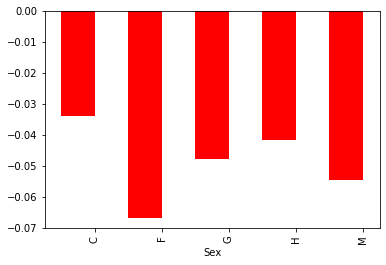

In [27]:
grouped.BspPot.plot(kind='bar', color='red', width=0.5, position=1)

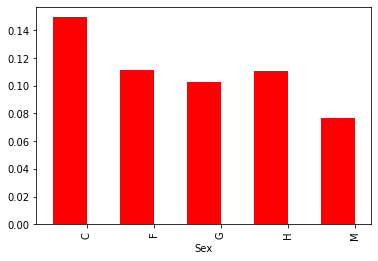

In [16]:
grouped.WinPct.plot(kind='bar', color='red', width=0.5, position=1)

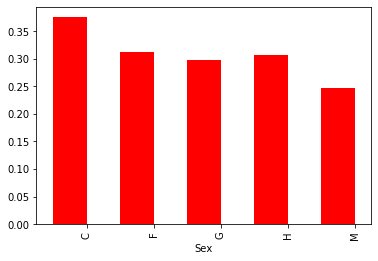

In [23]:
grouped.PlacePct.plot(kind='bar', color='red', width=0.5, position=1)

## Repeat for race 1100m and less

In [28]:
grouped1100m = GroupBySex(merged2[merged2.distance <= 1100])
grouped1100m.head(10)

,Wins,Runners,Places,BspBetSize,BspProfit,TabBetSize,TabProfit,BspPot,TabPot,WinPct,PlacePct
Sex,,,,,,,,,,,
C,367.0,2463,927.0,37407.259416,-2635.105274,42624.206547,-5924.206547,-0.070444,-0.138987,0.149005,0.376370
F,1744.0,15422,4912.0,174861.897972,-9871.686922,205671.730959,-31271.730959,-0.056454,-0.152047,0.113085,0.318506
G,1647.0,15083,4658.0,161554.233019,-5699.142677,189969.763422,-25269.763422,-0.035277,-0.133020,0.109196,0.308825
H,15.0,187,57.0,2027.712671,-598.208333,2403.742619,-903.742619,-0.295016,-0.375973,0.080214,0.304813
M,553.0,7408,1875.0,56804.579061,-4698.758037,69639.954849,-14339.954849,-0.082718,-0.205916,0.074649,0.253105


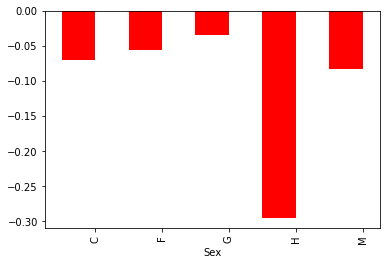

In [31]:
grouped1100m.BspPot.plot(kind='bar', color='red', width=0.5, position=1)

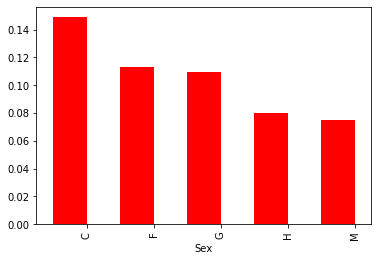

In [33]:
grouped1100m.WinPct.plot(kind='bar', color='red', width=0.5, position=1)

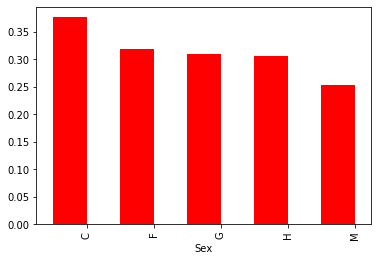

In [34]:
grouped1100m.PlacePct.plot(kind='bar', color='red', width=0.5, position=1)